In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2022-12-06 18:22:39.337512: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 18:22:39.337635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Device: grpc://10.0.0.2:8470


2022-12-06 18:22:47.914113: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 18:22:47.917156: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 18:22:47.917198: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 18:22:47.917223: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (64a1d9a6a8df): /proc/driver/nvidia/version does not exist
2022-12-06 18:22:47.920133: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8
2.4.1


# Load in the data

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-12-06 18:22:54.564497: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-06 18:22:54.615203: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [3]:
IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(10000)
    return dataset

In [4]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=50).batch(100, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=2  ).batch(100, drop_remainder=True)

# DCGAN
## Network Upsample and Downsample

In [5]:
OUTPUT_CHANNELS = 3
LATENT_DIM = 1024

def downsample(filters, size, activation, dropout, apply_instancenorm=True, 
                                                   apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    #result.add(layers.MaxPool2D()) replaced

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(dropout))
    
    if activation == "leakyrelu":
        result.add(layers.LeakyReLU())
    elif activation == "relu":
        result.add(layers.ReLU())

    return result

In [6]:
def upsample(filters, size, activation, dropout, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(dropout))

    if activation == "leakyrelu":
        result.add(layers.LeakyReLU())
    elif activation == "relu":
        result.add(layers.ReLU())

    return result

## Build Network


In [7]:
EPOCHS = 50

gen_lrate = 0.0002
dis_lrate = 0.0002

beta_1=0.9
beta_2=0.999

label_real = .9

In [8]:
def CycleGenerator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, "relu", 0.8, apply_instancenorm=False, apply_dropout=True),
        downsample(128, 4, "relu", 0.5, apply_dropout=True),
        downsample(256, 4, "relu", 0.5, apply_dropout=True),
        downsample(512, 4, "relu", 0.5),
        #downsample(512, 4, "relu", 0.5),
        #downsample(512, 4, "relu", 0.5),
        #downsample(512, 4, "relu", 0.5),
        #downsample(512, 4, "relu", 0.5),
    ]

    up_stack = [
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        #upsample(512, 4, "relu", 0.5, apply_dropout=True),
        #upsample(512, 4, "relu", 0.5, apply_dropout=True),
        #upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(256, 4, "relu", 0.5, apply_dropout=False),
        upsample(128, 4, "relu", 0.5, apply_dropout=False), 
        upsample(64, 4, "relu", 0.5, apply_dropout=False),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [9]:
def CycleDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, "leakyrelu", 0.8, apply_instancenorm = False, apply_dropout=True)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, "leakyrelu", 0.5)(down1)
    down3 = downsample(256, 4, "leakyrelu", 0.5)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last_conv = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
with strategy.scope():
    monet_cycle_generator = CycleGenerator() # Photos to Monet 
    photo_cycle_generator = CycleGenerator() #  Monet to Photos

    monet_cycle_discriminator = CycleDiscriminator() 
    photo_cycle_discriminator = CycleDiscriminator() 

##CycleGAN model


In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        label_real=.5
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.label_real = label_real
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_photo)[0]
        labels_real = tf.zeros((batch_size, 1)) + self.label_real
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))        
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_gen_loss = self.gen_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Loss functions


In [12]:
with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2) +
                tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2))/2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
                tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)) / 2

In [13]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [14]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train

In [15]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(gen_lrate, beta_1=0.9, beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(gen_lrate,  beta_1=0.9, beta_2=0.999)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(dis_lrate,  beta_1=0.9, beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(dis_lrate,  beta_1=0.9, beta_2=0.999)

In [16]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_cycle_generator, photo_cycle_generator, monet_cycle_discriminator, photo_cycle_discriminator, label_real=0.66
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [17]:
from tensorflow.keras.utils import plot_model

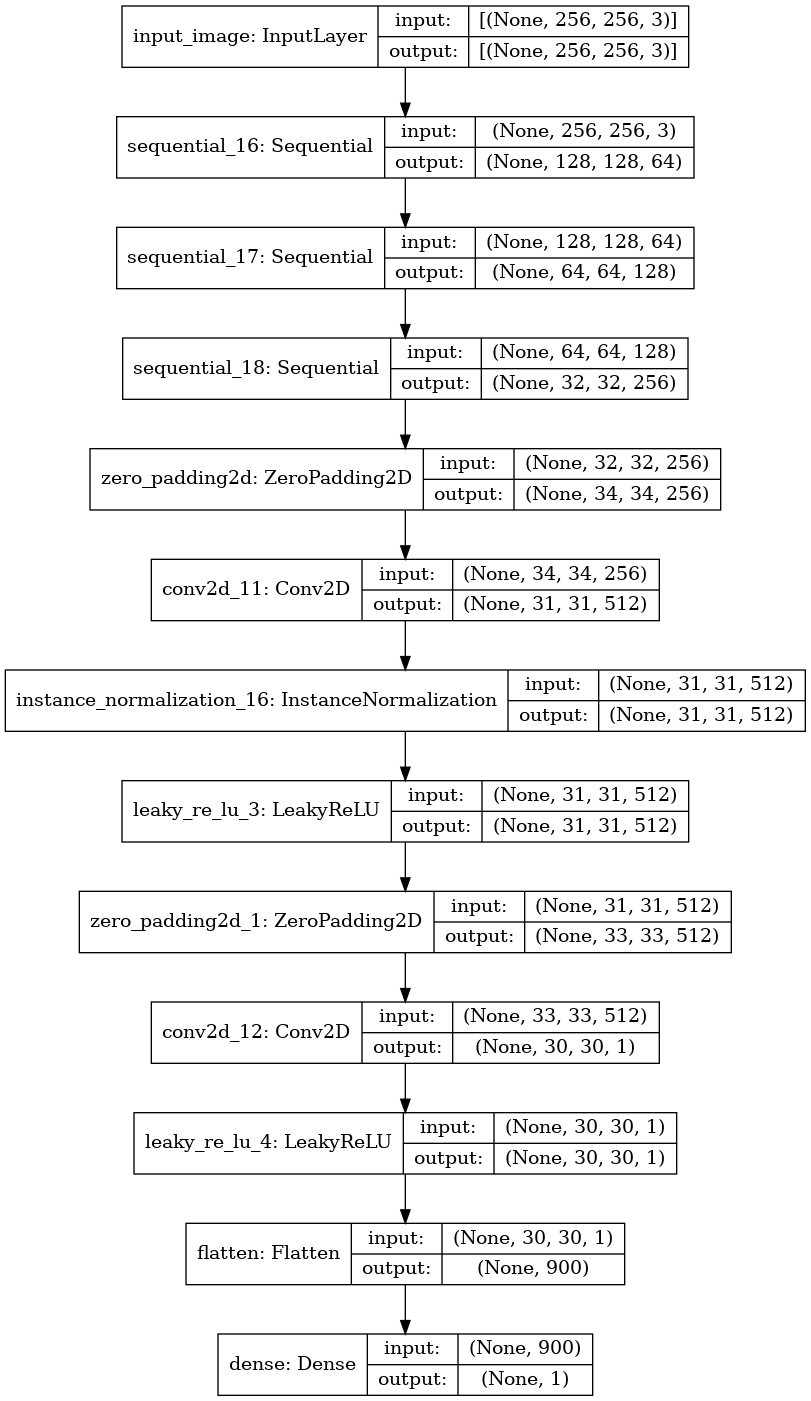

In [18]:
plot_model(monet_cycle_discriminator, to_file = 'd_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50
306/306 [==============================] - 177s 324ms/step - monet_gen_loss: 6.6910 - photo_gen_loss: 6.8797 - monet_disc_loss: 0.2298 - photo_disc_loss: 0.2522
Epoch 2/50


2022-12-06 18:26:01.246136: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 9260, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670351161.242578327","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 9260, Output num: 0","grpc_status":3}


306/306 [==============================] - 102s 323ms/step - monet_gen_loss: 4.7771 - photo_gen_loss: 4.9620 - monet_disc_loss: 0.3182 - photo_disc_loss: 0.2783
Epoch 3/50
306/306 [==============================] - 101s 322ms/step - monet_gen_loss: 4.4617 - photo_gen_loss: 4.8775 - monet_disc_loss: 0.3658 - photo_disc_loss: 0.2554
Epoch 4/50
306/306 [==============================] - 105s 333ms/step - monet_gen_loss: 4.1451 - photo_gen_loss: 5.1478 - monet_disc_loss: 0.4304 - photo_disc_loss: 0.1178
Epoch 5/50
306/306 [==============================] - 101s 322ms/step - monet_gen_loss: 4.2327 - photo_gen_loss: 5.2144 - monet_disc_loss: 0.3886 - photo_disc_loss: 0.1052
Epoch 6/50
306/306 [==============================] - 103s 327ms/step - monet_gen_loss: 4.1373 - photo_gen_loss: 5.1858 - monet_disc_loss: 0.4177 - photo_disc_loss: 0.1204
Epoch 7/50
306/306 [==============================] - 103s 326ms/step - monet_gen_loss: 4.5050 - photo_gen_loss: 5.4029 - monet_disc_loss: 0.2635 - pho

In [20]:
loss_G_A = history.history['monet_gen_loss']

In [21]:
loss_G_A

[4.7043046951293945,
 4.2979607582092285,
 3.9661378860473633,
 3.624760150909424,
 4.071188449859619,
 4.391403675079346,
 4.609636306762695,
 4.1419358253479,
 4.302745342254639,
 4.032756805419922,
 4.318194389343262,
 3.8694872856140137,
 4.094524383544922,
 3.747073173522949,
 4.294036865234375,
 4.476332187652588,
 4.130443572998047,
 3.9572083950042725,
 3.9995241165161133,
 4.562507152557373,
 4.329716682434082,
 4.746065616607666,
 4.252255916595459,
 4.4196343421936035,
 4.36439323425293,
 4.169867515563965,
 4.473256587982178,
 4.58308219909668,
 4.254406452178955,
 4.077434539794922,
 4.542790412902832,
 4.061825275421143,
 4.208634853363037,
 4.159647464752197,
 4.1737494468688965,
 4.106985092163086,
 3.47082257270813,
 3.2788496017456055,
 3.721067190170288,
 4.115629196166992,
 4.308706760406494,
 4.086315155029297,
 4.4135847091674805,
 4.437891483306885,
 4.021262168884277,
 3.6117334365844727,
 3.6855008602142334,
 3.755626678466797,
 3.1170339584350586,
 3.707921504

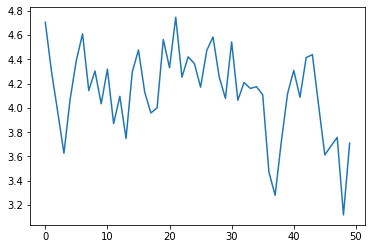

In [22]:
plt.plot(loss_G_A, label="Generator A")

# Visualize

In [32]:
_, ax = plt.subplots(2, 3, figsize=(26, 9))
for i, img in enumerate(photo_ds.take(3)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Photo")
    ax[1, i].set_title("Monet")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()

In [24]:
monet_cycle_discriminator.save("../models/monet_cycle_discriminator_100.h5")

In [25]:
photo_cycle_discriminator.save("../models/photo_cycle_discriminator_100.h5")

In [26]:
photo_cycle_generator.save("../models/photo_cycle_generator_100.h5")

In [27]:
monet_cycle_generator.save("../models/monet_cycle_generator_100.h5")

In [28]:
import shutil
shutil.make_archive("/kaggle/working/models", 'zip', "/kaggle/models")

'/kaggle/working/models.zip'